In [1]:
import seaborn as sns


tbd

In [2]:
from pathlib import Path
import json

# Root folder where your nested folders are located
root_folder = Path("../data//dataset_sw+fw")  # replace with your top-level folder

# Recursively find all JSON files
json_files = list(root_folder.rglob("*.json"))

print(f"Found {len(json_files)} JSON files.")

# Example: load each JSON file
for file_path in json_files:
    with open(file_path) as f:
        data = json.load(f)
        # Now you can use 'data', e.g., classify IoT type
        print(f"Loaded {file_path.name}")


Found 658 JSON files.
Loaded CVE-2022-32259.json
Loaded CVE-2019-4640.json
Loaded CVE-2022-38101.json
Loaded CVE-2019-1880.json
Loaded CVE-2022-38625.json
Loaded CVE-2023-45779.json
Loaded CVE-2020-0996.json
Loaded CVE-2018-19234.json
Loaded CVE-2020-2032.json
Loaded CVE-2017-8665.json
Loaded CVE-2022-25291.json
Loaded CVE-2021-36021.json
Loaded CVE-2021-22790.json
Loaded CVE-2021-3485.json
Loaded CVE-2021-28191.json
Loaded CVE-2023-0392.json
Loaded CVE-2020-10831.json
Loaded CVE-2018-6221.json
Loaded CVE-2021-33090.json
Loaded CVE-2022-34471.json
Loaded CVE-2023-30702.json
Loaded CVE-2021-1426.json
Loaded CVE-2016-4741.json
Loaded CVE-2022-24644.json
Loaded CVE-2021-46442.json
Loaded CVE-2021-38634.json
Loaded CVE-2019-7229.json
Loaded CVE-2019-1289.json
Loaded CVE-2023-34937.json
Loaded CVE-2021-26930.json
Loaded CVE-2019-6742.json
Loaded CVE-2023-6321.json
Loaded CVE-2023-35749.json
Loaded CVE-2017-6445.json
Loaded CVE-2019-17190.json
Loaded CVE-2017-9316.json
Loaded CVE-2020-3342.j

Prepare the training dataset (important step)
Use ONLY the CVE description text

In [3]:
def extract_description(cve_json):
    try:
        descs = cve_json["containers"]["cna"].get("descriptions", [])
        if descs:
            return descs[0]["value"]
    except KeyError:
        pass
    return ""


Showing  random CVE description samples:


In [4]:
# Preview sample CVE descriptions to ensure extraction works
import random

sample_files = random.sample(json_files, min(5, len(json_files)))  # pick up to 5 random files

print(f"Showing {len(sample_files)} random CVE description samples:\n")

for path in sample_files:
    with open(path) as f:
        cve_data = json.load(f)
    desc = extract_description(cve_data)
    print(f"{path.name}: {desc[:300]}")
    #print(f"Description: {desc[:300]}")  # show first 300 chars for brevity
    #print("-" * 80)


Showing 5 random CVE description samples:

CVE-2021-26889.json: Windows Update Stack Elevation of Privilege Vulnerability
CVE-2021-24240.json: The Business Hours Pro WordPress plugin through 5.5.0 allows a remote attacker to upload arbitrary files using its manual update functionality, leading to an unauthenticated remote code execution vulnerability.
CVE-2019-9745.json: CloudCTI HIP Integrator Recognition Configuration Tool allows privilege escalation via its EXQUISE integration. This tool communicates with a service (Recognition Update Client Service) via an insecure communication channel (Named Pipe). The data (JSON) sent via this channel is used to import data f
CVE-2023-35747.json: D-Link DAP-2622 DDP Firmware Upgrade Auth Password Stack-based Buffer Overflow Remote Code Execution Vulnerability. This vulnerability allows network-adjacent attackers to execute arbitrary code on affected installations of D-Link DAP-2622 routers. Authentication is not required to exploit this vuln
CVE



Define the label space (fixed & explicit)

In [5]:

LABELS = [
    "Home",
    "SCADA",
    "Enterprise",
    "Mobile",
    "PC",
    "Other"
]

label2id = {l: i for i, l in enumerate(LABELS)}
id2label = {i: l for l, i in label2id.items()}


Convert rule-based output to label ID

In [6]:
def normalize_label(rule_label):
    if "Home" in rule_label:
        return "Home"
    if "SCADA" in rule_label:
        return "SCADA"
    if "Enterprise" in rule_label:
        return "Enterprise"
    if "Mobile" in rule_label:
        return "Mobile"
    if "PC" in rule_label:
        return "PC"
    return "Other"


 Smart Rule-Based with Word Context

In [7]:
# ==================== 4.  RULE-BASED CLASSIFIER ====================
import re
def classify_cve_iot_category(cve):
    """Enhanced rule-based classifier with better keyword coverage"""
    desc = extract_description(cve).lower()
    
    # Expanded keywords based on actual CVE patterns
    patterns = {
        "Home": [
            # Smart home devices
            r"smart\s+(home|thermostat|bulb|lock|speaker|tv|plug|camera|doorbell)",
            r"iot\s+device",
            r"connected\s+device",
            r"home\s+automation",
            # Network devices (home/SOHO)
            r"\b(router|wifi|wireless)\s+(router|access\s+point|device)",
            r"\b(tplink|d-link|asus|netgear|linksys|nest|ring|arlo|wyze|roku)\b",
            # Home security
            r"security\s+camera",
            r"ip\s+camera",
            r"baby\s+monitor",
            # Home entertainment
            r"smart\s+tv",
            r"streaming\s+device",
            r"gaming\s+console",
            # Keywords from your data
            r"\b(soho|home\s+router)\b"
        ],
        
        "SCADA": [
            # Industrial systems
            r"\b(scada|ics|plc|hmi|rtu|dcs)\b",
            r"industrial\s+control",
            r"process\s+control",
            r"supervisory\s+control",
            # Critical infrastructure
            r"power\s+(grid|plant|station)",
            r"water\s+treatment",
            r"\b(oil|gas)\s+.*\s+(plant|refinery|pipeline)",
            # Medical devices
            r"medical\s+device",
            r"patient\s+monitor",
            r"hospital\s+equipment",
            # Manufacturing
            r"\b(manufacturing|factory|plant)\b",
            # Automotive
            r"\b(automotive|vehicle|car)\b",
            r"engine\s+control"
        ],
        
        "Enterprise": [
            # Enterprise context
            r"enterprise\s+(network|system|software|application)",
            r"business\s+(network|application)",
            r"corporate\s+(network|environment)",
            # Cloud and servers
            r"cloud\s+(service|infrastructure|platform)",
            r"data\s+center",
            r"server\s+(software|application|side|hardware)",
            # Networking equipment
            r"\b(switch|firewall|vpn|load\s+balancer)\b",
            # Specific enterprise brands
            r"\b(cisco|juniper|paloalto|fortinet|vmware|oracle|sap|microsoft\s+server)\b",
            # Storage
            r"storage\s+system",
            r"\b(nas|san)\b"
        ],
        
        "Mobile": [
            # Mobile devices
            r"\b(android|ios|iphone|ipad|smartphone|tablet)\b",
            r"mobile\s+(device|phone|application|app|os)",
            # Mobile context
            r"google\s+play",
            r"app\s+store",
            # Wearables
            r"\b(smartwatch|wearable|fitness\s+tracker)\b",
            # Mobile networks
            r"\b(5g|lte|cellular)\b"
        ],
        
        "PC": [
            # Personal computers
            r"\b(pc|computer|desktop|laptop|notebook)\b",
            r"personal\s+computer",
            # Operating systems
            r"\b(windows|linux|macos|ubuntu|debian|centos|red\s+hat)\b",
            r"operating\s+system",
            # PC components
            r"\b(bios|uefi|cpu|gpu|ram|ssd|hard\s+drive|motherboard)\b",
            # PC software
            r"\b(microsoft\s+office|adobe|antivirus|browser)\b",
            # Specific terms from your data
            r"\b(intel\s+nuc|chrome\s+os)\b"
        ]
    }


    # Score categories
    scores = {}
    for category, regex_list in patterns.items():
        score = 0
        for pattern in regex_list:
            matches = re.findall(pattern, desc)
            if matches:
                # Multi-word patterns get higher weight
                if "\\s" in pattern:
                    score += len(matches) * 3
                else:
                    score += len(matches) * 2
        if score > 0:
            scores[category] = score
    
    # Return best match if above threshold
    if scores:
        best_category, best_score = max(scores.items(), key=lambda x: x[1])
        if best_score >= 2:  # Lower threshold to catch more cases
            return best_category
    
    return "Other"

##### Building dataset with rule-based classification...

In [8]:
# ==================== 5. BUILD DATASET ====================
from datasets import Dataset

texts = []
labels = []
rule_predictions = []

for json_file in json_files:
    with open(json_file) as f:
        try:
            cve = json.load(f)
        except json.JSONDecodeError:
            continue
    
    desc = extract_description(cve)
    if desc.strip() == "":
        continue
    
    # Use improved classifier
    rule_label = classify_cve_iot_category(cve)
    label_id = label2id[rule_label]
    
    texts.append(desc)
    labels.append(label_id)
    rule_predictions.append(rule_label)

# Create dataset
dataset = Dataset.from_dict({
    "text": texts,
    "label": labels
})

In [9]:
# ==================== 6. PRINT CLASS DISTRIBUTION ====================
import pandas as pd

print("\n" + "="*50)
print(" Rule-Based Classification Distribution")
print("="*50)

# Desired fixed class order
CLASS_ORDER = ["Home", "SCADA", "Enterprise", "Mobile", "PC", "Other"]

# Create DataFrame
dist_df = pd.DataFrame({
    "IoT_Class": rule_predictions,
    "Label_ID": labels
})

# Count distribution
dist_counts = dist_df["IoT_Class"].value_counts().reindex(CLASS_ORDER, fill_value=0).reset_index()
dist_counts.columns = ["IoT_Class", "Count"]

# Add percentage
dist_counts["Percentage"] = (dist_counts["Count"] / len(dataset) * 100).round(1)

# Print formatted distribution
print("\n IoT Class Distribution:")
print("-" * 35)

for idx, row in dist_counts.iterrows():
    print(f"{idx+1:2d}  {row['IoT_Class']:15s} {row['Count']:5d} ({row['Percentage']}%)")



 Rule-Based Classification Distribution

 IoT Class Distribution:
-----------------------------------
 1  Home               26 (4.0%)
 2  SCADA              16 (2.4%)
 3  Enterprise         43 (6.5%)
 4  Mobile             24 (3.6%)
 5  PC                145 (22.0%)
 6  Other             404 (61.4%)


/tmp/ipykernel_21366/3775126955.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


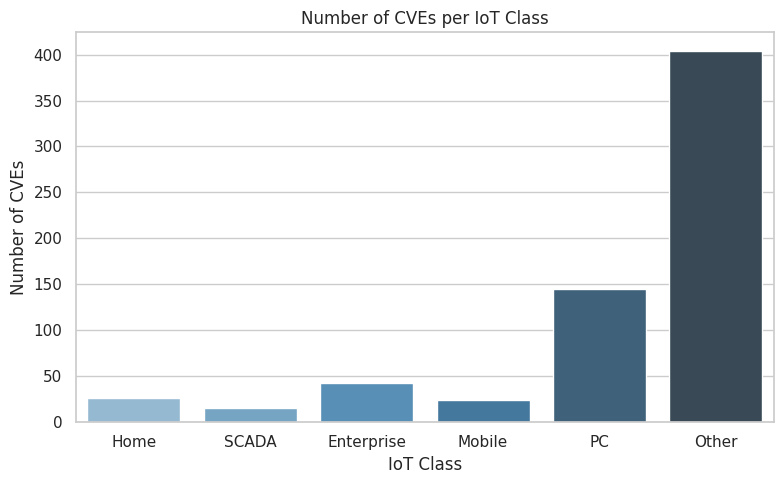

In [10]:
# ==================== PLOT CVE DISTRIBUTION ====================
from matplotlib import pyplot as plt


sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))

# DON'T recreate dist_counts here - it's already calculated above!
# Use the existing dist_counts variable from line 8

sns.barplot(
    data=dist_counts,  # This should use the existing dist_counts
    x="IoT_Class",
    y="Count",
    order=dist_counts["IoT_Class"],  # keep the order from your table
    palette="Blues_d"
)

plt.title("Number of CVEs per IoT Class")
plt.xlabel("IoT Class")
plt.ylabel("Number of CVEs")
plt.xticks(rotation=0)  # rotate if labels are long
plt.tight_layout()
plt.show()

In [11]:
#dist_counts = pd.DataFrame()  # empty, reset for plot 


In [12]:
# ====================   RANDOM DESCRIPTIONS PER CLASS ====================
print(" 3 Random CVE Descriptions per IoT Class")
print("="*50)

for idx, row in dist_counts.iterrows():
    cls = row["IoT_Class"]
    indices = [i for i, l in enumerate(rule_predictions) if l == cls]

    if not indices:
        continue

    random.shuffle(indices)
    print(f"\n{idx+1}. {cls.upper()}")

    for i in indices[:3]:
        cve_name = Path(json_files[i]).name

        with open(json_files[i], "r", encoding="utf-8") as f:
            desc = extract_description(json.load(f))

        print(f" {cve_name}: {desc[:150]}{'...' if len(desc) > 150 else ''}")

 3 Random CVE Descriptions per IoT Class

1. HOME
 CVE-2023-35749.json: D-Link DAP-2622 DDP Firmware Upgrade Filename Stack-based Buffer Overflow Remote Code Execution Vulnerability. This vulnerability allows network-adjac...
 CVE-2023-30356.json: Missing Support for an Integrity Check in Shenzen Tenda Technology IP Camera CP3 V11.10.00.2211041355 allows attackers to update the device with craft...
 CVE-2023-35721.json: NETGEAR Multiple Routers curl_post Improper Certificate Validation Remote Code Execution Vulnerability. This vulnerability allows network-adjacent att...

2. SCADA
 CVE-2019-6844.json: A CWE-755: Improper Handling of Exceptional Conditions vulnerability exists in Modicon M580, Modicon M340, Modicon BMxCRA and 140CRA modules (all firm...
 CVE-2019-6841.json: A CWE-755: Improper Handling of Exceptional Conditions vulnerability exists in Modicon M580 with firmware (version prior to V3.10), Modicon M340 (all ...
 CVE-2016-6567.json: SHDesigns' Resident Download Manager prov

### Adding Vendor and product
##### i think adding keywords from the vendors and products names would improve my rule-based

In [13]:
def extract_vendor_product(cve_json):
    """Extract vendor and product information from CVE JSON"""
    vendor = "Unknown"
    product = "Unknown"
    
    try:
        # Try to get from affected section in cna
        affected = cve_json["containers"]["cna"].get("affected", [])
        if affected:
            vendor = affected[0].get("vendor", "Unknown")
            product = affected[0].get("product", "Unknown")
    except (KeyError, IndexError):
        pass
    
    # Also check adp section if not found
    if vendor == "Unknown":
        try:
            adp = cve_json["containers"].get("adp", [])
            for item in adp:
                affected = item.get("affected", [])
                if affected:
                    vendor = affected[0].get("vendor", "Unknown")
                    product = affected[0].get("product", "Unknown")
                    if vendor != "Unknown":
                        break
        except (KeyError, IndexError):
            pass
    
    return vendor, product

reve

In [14]:
# ==================== 3. PREVIEW DATA WITH VENDOR/PRODUCT INFO ====================
print("\n" + "="*50)
print("Previewing CVE data with vendor/product information")
print("="*50)

import random
sample_files = random.sample(json_files, min(100, len(json_files)))

print(f"\nShowing {len(sample_files)} random CVE samples with vendor/product info:\n")

for path in sample_files:
    with open(path) as f:
        cve_data = json.load(f)
    
    desc = extract_description(cve_data)
    vendor, product = extract_vendor_product(cve_data)
    
    print(f" {path.name}:")
    print(f"   Vendor: {vendor}")
    print(f"   Product: {product}")
    print(f"   Description: {desc[:150]}...")
    print("-" * 80)



Previewing CVE data with vendor/product information

Showing 100 random CVE samples with vendor/product info:

 CVE-2019-15310.json:
   Vendor: n/a
   Product: n/a
   Description: An issue was discovered on various devices via the Linkplay firmware. There is WAN remote code execution without user interaction. An attacker could r...
--------------------------------------------------------------------------------
 CVE-2023-24453.json:
   Vendor: Jenkins Project
   Product: Jenkins TestQuality Updater Plugin
   Description: A missing check in Jenkins TestQuality Updater Plugin 1.3 and earlier allows attackers with Overall/Read permission to connect to an attacker-specifie...
--------------------------------------------------------------------------------
 CVE-2023-28070.json:
   Vendor: Dell
   Product: Alienware Command Center (AWCC)
   Description: 
Alienware Command Center Application, versions 5.5.43.0 and prior, contain an improper access control vulnerability. A local malicious use

In [15]:
# Define known vendors and products for each category
vendor_categories = {
    "Home": [
        "d-link", "tplink", "asus", "netgear", "linksys", "nest", "ring", "arlo", 
        "wyze", "roku", "google", "amazon", "apple", "samsung", "xiaomi", "philips",
        "hue", "smartthings", "ecobee", "arlo", "eufy", "blink", "simplisafe",
        "logitech", "harman", "sonos", "bose", "jbl", "belkin", "meross", "tuya"
    ],
    "SCADA": [
        "siemens", "rockwell", "schneider", "abb", "emerson", "honeywell", "yokogawa",
        "mitsubishi", "omron", "fanuc", "beckhoff", "wago", "moxa", "advantech",
        "b&r", "panasonic", "delta", "fujitsu", "hitachi", "toshiba", "general electric",
        "ge", "allen-bradley", "modicon", "telemecanique", "square d", "cutler-hammer"
    ],
    "Enterprise": [
        "cisco", "juniper", "paloalto", "fortinet", "checkpoint", "f5", "arista",
        "extreme", "brocade", "hp", "hewlett-packard", "dell", "ibm", "oracle",
        "sap", "vmware", "red hat", "microsoft", "intel", "amd", "nvidia", "qualcomm",
        "broadcom", "marvell", "micron", "sandisk", "seagate", "western digital",
        "synology", "qnap", "netapp", "emc", "hitachi", "huawei", "zte", "ericsson",
        "nokia", "motorola", "aruba", "ruckus", "ubiquiti"
    ],
    "Mobile": [
        "apple", "samsung", "google", "huawei", "xiaomi", "oppo", "vivo", "oneplus",
        "sony", "lg", "motorola", "nokia", "htc", "blackberry", "asus", "lenovo",
        "zte", "alcatel", "realme", "tecno", "infinix", "fairphone", "nothing"
    ],
    "PC": [
        "dell", "hp", "hewlett-packard", "lenovo", "asus", "acer", "msi", "gigabyte",
        "intel", "amd", "nvidia", "microsoft", "apple", "toshiba", "fujitsu", "samsung",
        "lg", "sony", "panasonic", "sharp", "nec", "epson", "brother", "canon", "ricoh",
        "kyocera", "xerox", "lexmark", "okidata", "konica", "minolta"
    ]
}

# Product keywords that indicate specific categories
product_keywords = {
    "Home": [
        "router", "access point", "mesh", "wifi", "camera", "doorbell", "thermostat",
        "bulb", "light", "plug", "outlet", "switch", "lock", "speaker", "display",
        "hub", "gateway", "bridge", "extender", "repeater", "adapter", "dongle"
    ],
    "SCADA": [
        "plc", "hmi", "rtu", "dcs", "scada", "ics", "controller", "automation",
        "drive", "inverter", "servo", "motor", "sensor", "actuator", "valve",
        "transmitter", "recorder", "logger", "monitor", "panel", "station"
    ],
    "Enterprise": [
        "switch", "firewall", "router", "load balancer", "server", "storage",
        "nas", "san", "array", "appliance", "gateway", "proxy", "vpn", "wireless",
        "controller", "management", "console", "director", "orchestrator", "hypervisor"
    ],
    "Mobile": [
        "phone", "smartphone", "tablet", "pad", "watch", "wearable", "tracker",
        "band", "bracelet", "ring", "glasses", "headset", "earbuds", "charger",
        "battery", "dock", "station", "adapter", "cable"
    ],
    "PC": [
        "laptop", "notebook", "desktop", "pc", "workstation", "server", "all-in-one",
        "mini", "stick", "dongle", "adapter", "card", "motherboard", "cpu", "gpu",
        "ram", "ssd", "hdd", "drive", "monitor", "display", "printer", "scanner",
        "copier", "fax", "projector", "keyboard", "mouse", "webcam", "microphone"
    ]
}

In [16]:
def enhanced_classify_cve(cve):
    """Enhanced classifier that uses vendor and product information"""
    desc = extract_description(cve).lower()
    vendor, product = extract_vendor_product(cve)
    vendor_lower = vendor.lower()
    product_lower = product.lower()
    
    # Initialize scores
    scores = {}
    
    # 1. Check vendor categories
    for category, vendors in vendor_categories.items():
        for known_vendor in vendors:
            if known_vendor in vendor_lower:
                scores[category] = scores.get(category, 0) + 3
    
    # 2. Check product keywords
    for category, keywords in product_keywords.items():
        for keyword in keywords:
            if keyword in product_lower:
                scores[category] = scores.get(category, 0) + 2
            if keyword in desc:
                scores[category] = scores.get(category, 0) + 1
    
    # 3. Use the original text-based classifier
    rule_label = classify_cve_iot_category(cve)
    if rule_label != "Other":
        scores[rule_label] = scores.get(rule_label, 0) + 2
    
    # Return best match if above threshold
    if scores:
        best_category, best_score = max(scores.items(), key=lambda x: x[1])
        if best_score >= 2:
            return best_category
    
    return "Other"

In [17]:
import random
import pandas as pd
from pathlib import Path
import json

# ==================== ENHANCED CLASSIFICATION ====================
texts = []
labels = []
rule_predictions = []
vendors = []
products = []

for json_file in json_files:
    with open(json_file, "r", encoding="utf-8") as f:
        try:
            cve = json.load(f)
        except json.JSONDecodeError:
            continue
    
    desc = extract_description(cve)
    if desc.strip() == "":
        continue
    
    vendor, product = extract_vendor_product(cve)
    
    # Use the enhanced classifier
    rule_label = enhanced_classify_cve(cve)
    label_id = label2id[rule_label]
    
    texts.append(desc)
    labels.append(label_id)
    vendors.append(vendor)
    products.append(product)
    rule_predictions.append(rule_label)

print(f"Enhanced classification complete: {len(rule_predictions)} CVEs")

# ==================== PRINT CLASS DISTRIBUTION ====================
print("\n" + "="*50)
print(" ENHANCED Class Distribution (with Vendor/Product info)")
print("="*50)

CLASS_ORDER = ["Home", "SCADA", "Enterprise", "Mobile", "PC", "Other"]

# Create DataFrame from the enhanced rule_predictions
dist_df = pd.DataFrame({
    "IoT_Class": rule_predictions,
    "Label_ID": labels
})

# Count distribution based on current enhanced data
dist_counts_vendor = dist_df["IoT_Class"].value_counts().reindex(CLASS_ORDER, fill_value=0).reset_index()
dist_counts_vendor.columns = ["IoT_Class", "Count"]
dist_counts_vendor["Percentage"] = (dist_counts_vendor["Count"] / len(dist_df) * 100).round(1)

# Print formatted distribution table
print("\n IoT Class Distribution (Enhanced):")
print("-" * 35)
for idx, row in dist_counts_vendor.iterrows():
    print(f"{idx+1:2d}  {row['IoT_Class']:15s} {row['Count']:5d} ({row['Percentage']}%)")

# ==================== RANDOM 3 CVEs PER CLASS ====================
print("\n" + "="*50)
print(" Random 3 CVEs per Class (Detailed)")
print("="*50)

# Shuffle classes for variety in sample display
random_classes = CLASS_ORDER.copy()
random.shuffle(random_classes)

for class_idx, class_name in enumerate(random_classes, 1):  # Start from 1
    # Indices of CVEs in this class
    class_indices = [i for i, label in enumerate(rule_predictions) if label == class_name]
    
    if class_indices:
        # Actual class index for numbering (fixed order)
        actual_class_idx = CLASS_ORDER.index(class_name) + 1
        
        print(f"\n{'-'*60}")
        print(f"{actual_class_idx}. {class_name.upper()} CLASS ({len(class_indices)} CVEs)")
        print('-'*60)
        
        # Randomly select 3 samples from this class
        if len(class_indices) > 3:
            selected_indices = random.sample(class_indices, 3)
        else:
            selected_indices = class_indices
        
        for sample_num, idx in enumerate(selected_indices, 1):  # Start from 1
            cve_name = Path(json_files[idx]).name if idx < len(json_files) else "Unknown"
            cve_vendor = vendors[idx] if idx < len(vendors) else "Unknown"
            cve_product = products[idx] if idx < len(products) else "Unknown"
            
            print(f"\n[{sample_num}] CVE: {cve_name}")
            print(f"    Vendor: {cve_vendor}")
            print(f"    Product: {cve_product}")
            
            # Get and print description
            if idx < len(json_files):
                with open(json_files[idx], "r", encoding="utf-8") as f:
                    cve_data = json.load(f)
                desc = extract_description(cve_data)
                
                # Short description (max 200 chars, try to end at a sentence)
                short_desc = desc[:200]
                if len(desc) > 200 and '.' in desc[150:200]:
                    last_period = desc[:200].rfind('.')
                    if last_period > 150:
                        short_desc = desc[:last_period+1]
                print(f"    Description: {short_desc}...")


Enhanced classification complete: 658 CVEs

 ENHANCED Class Distribution (with Vendor/Product info)

 IoT Class Distribution (Enhanced):
-----------------------------------
 1  Home               48 (7.3%)
 2  SCADA              55 (8.4%)
 3  Enterprise        119 (18.1%)
 4  Mobile             33 (5.0%)
 5  PC                153 (23.3%)
 6  Other             250 (38.0%)

 Random 3 CVEs per Class (Detailed)

------------------------------------------------------------
6. OTHER CLASS (250 CVEs)
------------------------------------------------------------

[1] CVE: CVE-2019-17584.json
    Vendor: n/a
    Product: n/a
    Description: The Meinberg SyncBox/PTP/PTPv2 devices have default SSH keys which allow attackers to get root access to the devices. All firmware versions up to v5.34o, v5.34s, v5.32* or 5.34g are affected....

[2] CVE: CVE-2022-46910.json
    Vendor: n/a
    Product: n/a
    Description: An issue in the firmware update process of TP-Link TL-WA901ND V1 up to v3.11.2 and TL

### There is improvments, see the privoius predctions, less on "Other" category





 Rule-Based Classification Distribution


 IoT Class Distribution: <br>
 1  Home               26 (4.0%)<br>
 2  SCADA              16 (2.4%)<br>
 3  Enterprise         43 (6.5%)<br>
 4  Mobile             24 (3.6%)<br>
 5  PC                145 (22.0%)<br>
 6  Other             404 (61.4%)<br>

/tmp/ipykernel_21366/2892053779.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


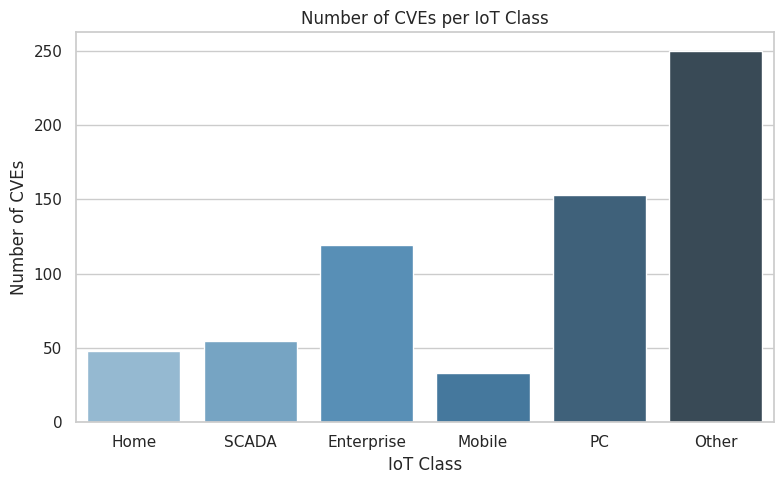

In [18]:
# ==================== PLOT CVE DISTRIBUTION ====================
from matplotlib import pyplot as plt


sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))



sns.barplot(
    data=dist_counts_vendor, 
    x="IoT_Class",
    y="Count",
    order=dist_counts_vendor["IoT_Class"],  # keep the order from your table
    palette="Blues_d"
)

plt.title("Number of CVEs per IoT Class")
plt.xlabel("IoT Class")
plt.ylabel("Number of CVEs")
plt.xticks(rotation=0)  # rotate if labels are long
plt.tight_layout()
plt.show()

#### I can see that my prector has improved, by extracting the both the vendor and prodcut names from the CVE <br> But i still need better way to reduce the bios towards "Other" and some false positive

In [ ]:
# Save the prepared dataset for later use
print("Saving prepared dataset...")
df.to_csv("prepared_cve_dataset.csv", index=False)
print("Dataset saved to 'prepared_cve_dataset.csv'")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Class distribution:\n{df['rule_based_label'].value_counts()}")

Saving prepared dataset...
Dataset saved to 'prepared_cve_dataset.csv'
Dataset shape: (658, 11)
Columns: ['file_name', 'text', 'description', 'vendor', 'product', 'reference_count', 'problem_type', 'impact', 'full_data', 'rule_based_label', 'label']
Class distribution:
rule_based_label
Other               232
PC                  126
Enterprise          125
Home_IoT             84
SCADA_Industrial     57
Mobile               34
Name: count, dtype: int64


## Problem 2 Using Machine learning


In [19]:
# ==================== PREPARE DATA FOR SVM ====================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

print("\n" + "="*60)
print("PREPARING SVM CLASSIFICATION")
print("="*60)

# Create a comprehensive DataFrame
data = []

for i, json_file in enumerate(json_files[:len(rule_predictions)]):  # Use only classified files
    with open(json_file, "r", encoding="utf-8") as f:
        try:
            cve = json.load(f)
        except json.JSONDecodeError:
            continue
    
    desc = extract_description(cve)
    if desc.strip() == "":
        continue
    
    vendor, product = extract_vendor_product(cve)
    
    data.append({
        "cve_id": Path(json_file).stem,
        "text": desc,
        "vendor": vendor.lower() if vendor != "Unknown" else "",
        "product": product.lower() if product != "Unknown" else "",
        "rule_label": rule_predictions[i],
        "vendor_product": f"{vendor.lower()} {product.lower()}" if vendor != "Unknown" and product != "Unknown" else ""
    })

df = pd.DataFrame(data)
print(f"\nTotal samples: {len(df)}")

# Let's see the distribution of 'Other' class
other_samples = df[df['rule_label'] == 'Other']
print(f"\n'Samples classified as 'Other': {len(other_samples)}")
print("\nTop 10 'Other' samples to understand why they weren't classified:")
for idx, row in other_samples.head(10).iterrows():
    print(f"\nCVE: {row['cve_id']}")
    print(f"Text snippet: {row['text'][:150]}...")
    print(f"Vendor/Product: {row['vendor_product']}")


PREPARING SVM CLASSIFICATION

Total samples: 658

'Samples classified as 'Other': 250

Top 10 'Other' samples to understand why they weren't classified:

CVE: CVE-2022-38625
Text snippet: Patlite NH-FB v1.46 and below was discovered to contain insufficient firmware validation during the upgrade firmware file upload process. This vulnera...
Vendor/Product: n/a n/a

CVE: CVE-2018-19234
Text snippet: The Miss Marple Updater Service in COMPAREX Miss Marple Enterprise Edition before 2.0 allows remote attackers to execute arbitrary code with SYSTEM pr...
Vendor/Product: n/a n/a

CVE: CVE-2022-25291
Text snippet: An integer overflow in WatchGuard Firebox and XTM appliances allows an authenticated remote attacker to trigger a heap-based buffer overflow and poten...
Vendor/Product: n/a n/a

CVE: CVE-2021-36021
Text snippet: Magento versions 2.4.2 (and earlier), 2.4.2-p1 (and earlier) and 2.3.7 (and earlier) are affected by an Improper input validation vulnerability within...
Vendor/Product: ad

In [20]:
# ==================== CREATE ENHANCED FEATURES ====================
def extract_keyword_features(text, vendor_product):
    """Extract keyword presence as features"""
    features = {}
    
    # Define keyword categories
    keywords = {
        'home': ['router', 'wifi', 'camera', 'smart', 'iot', 'home', 'thermostat', 
                 'doorbell', 'plug', 'bulb', 'speaker', 'hub', 'gateway'],
        'scada': ['scada', 'plc', 'hmi', 'industrial', 'control', 'automation',
                 'factory', 'plant', 'manufacturing', 'process', 'supervisory'],
        'enterprise': ['server', 'enterprise', 'business', 'corporate', 'cloud',
                      'data center', 'switch', 'firewall', 'vpn', 'storage'],
        'mobile': ['android', 'ios', 'iphone', 'mobile', 'smartphone', 'tablet',
                  'app', 'application', 'play store', 'app store'],
        'pc': ['windows', 'linux', 'macos', 'computer', 'pc', 'desktop', 'laptop',
              'operating system', 'os', 'software', 'application']
    }
    
    text_lower = text.lower()
    vendor_lower = vendor_product.lower()
    combined_text = f"{text_lower} {vendor_lower}"
    
    for category, words in keywords.items():
        for word in words:
            # Check if keyword appears in text
            if word in text_lower:
                features[f'text_{category}_{word}'] = 1
            else:
                features[f'text_{category}_{word}'] = 0
            # Check if keyword appears in vendor/product
            if word in vendor_lower:
                features[f'vendor_{category}_{word}'] = 1
            else:
                features[f'vendor_{category}_{word}'] = 0
    
    return features

# Create feature matrix
print("\nCreating feature matrix...")
features_list = []
for _, row in df.iterrows():
    features = extract_keyword_features(row['text'], row['vendor_product'])
    features_list.append(features)

features_df = pd.DataFrame(features_list)

# Add text features using TF-IDF
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
text_features = tfidf.fit_transform(df['text'])
text_features_df = pd.DataFrame(text_features.toarray(), 
                                columns=[f'tfidf_{i}' for i in range(text_features.shape[1])])

# Combine all features
X = pd.concat([features_df.reset_index(drop=True), 
               text_features_df.reset_index(drop=True)], axis=1)
y = df['rule_label'].values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")


Creating feature matrix...
Creating TF-IDF features...

Feature matrix shape: (658, 610)
Labels shape: (658,)



TRAINING SVM MODEL
Training samples: 526
Testing samples: 132

SVM MODEL EVALUATION

Accuracy: 0.773

Classification Report:
              precision    recall  f1-score   support

        Home       0.78      0.58      0.67        24
       SCADA       0.70      0.70      0.70        10
  Enterprise       0.75      0.50      0.60         6
      Mobile       0.71      0.94      0.81        50
          PC       0.90      0.87      0.89        31
       Other       1.00      0.36      0.53        11

    accuracy                           0.77       132
   macro avg       0.81      0.66      0.70       132
weighted avg       0.79      0.77      0.76       132



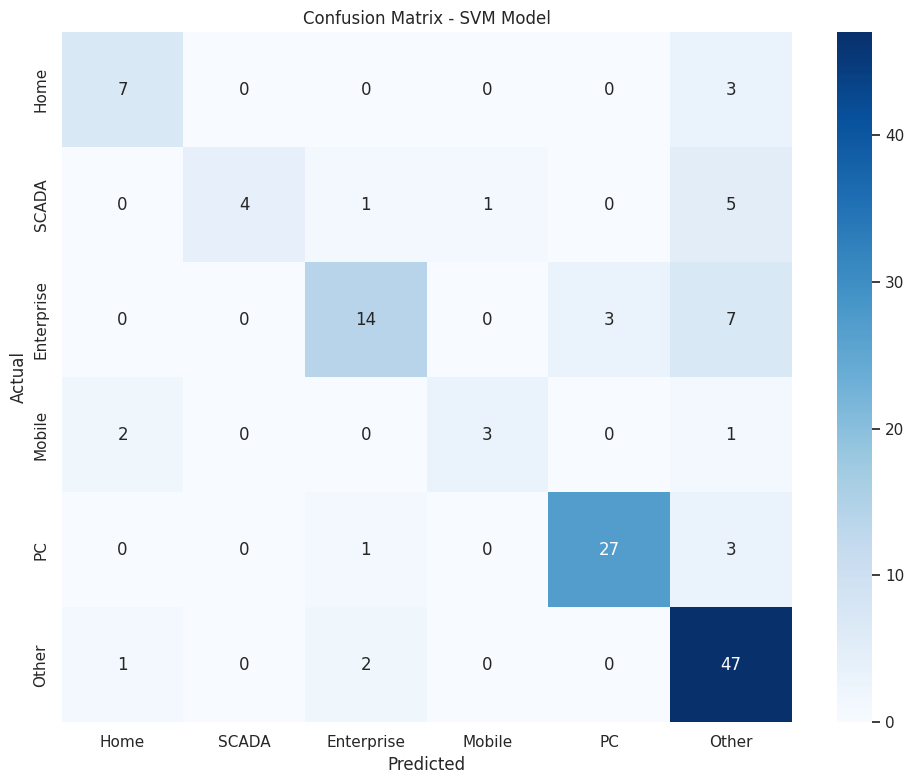

In [21]:
# ==================== TRAIN SVM MODEL ====================
print("\n" + "="*60)
print("TRAINING SVM MODEL")
print("="*60)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# Train SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
svm_model.fit(X_train, y_train)

# Predict on test set
y_pred = svm_model.predict(X_test)

# Evaluate model
print("\n" + "="*60)
print("SVM MODEL EVALUATION")
print("="*60)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=LABELS))

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred, labels=LABELS)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=LABELS, yticklabels=LABELS)
plt.title('Confusion Matrix - SVM Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [22]:
# ==================== RECLASSIFY "OTHER" SAMPLES ====================
print("\n" + "="*60)
print("RECLASSIFYING 'OTHER' SAMPLES")
print("="*60)

# Get samples originally classified as "Other"
other_indices = df[df['rule_label'] == 'Other'].index
X_other = X.loc[other_indices]

# Predict with SVM
other_predictions = svm_model.predict(X_other)
other_probabilities = svm_model.predict_proba(X_other)

# Create new classification
df['svm_label'] = df['rule_label']
df['svm_confidence'] = 0.0

for idx, original_idx in enumerate(other_indices):
    predicted_label = other_predictions[idx]
    confidence = np.max(other_probabilities[idx])
    
    # Only reclassify if confidence is high enough
    if confidence > 0.6 and predicted_label != 'Other':  # Adjust threshold as needed
        df.at[original_idx, 'svm_label'] = predicted_label
        df.at[original_idx, 'svm_confidence'] = confidence

# Compare distributions
print("\nBEFORE SVM Reclassification:")
print("-" * 40)
rule_counts = df['rule_label'].value_counts().reindex(LABELS, fill_value=0)
for label in LABELS:
    count = rule_counts.get(label, 0)
    percentage = (count / len(df) * 100)
    print(f"{label:15s}: {count:4d} ({percentage:.1f}%)")

print("\nAFTER SVM Reclassification:")
print("-" * 40)
svm_counts = df['svm_label'].value_counts().reindex(LABELS, fill_value=0)
for label in LABELS:
    count = svm_counts.get(label, 0)
    percentage = (count / len(df) * 100)
    print(f"{label:15s}: {count:4d} ({percentage:.1f}%)")

# Calculate how many were reclassified
reclassified = df[(df['rule_label'] == 'Other') & (df['svm_label'] != 'Other')]
print(f"\nReclassified {len(reclassified)} samples from 'Other' to specific categories")
print(f"Reclassification rate: {len(reclassified)/len(other_samples)*100:.1f}%")

# Show some reclassified examples
print("\n" + "="*60)
print("EXAMPLES OF RECLASSIFIED CVEs")
print("="*60)

if len(reclassified) > 0:
    sample_reclassified = reclassified.sample(min(5, len(reclassified)))
    for idx, row in sample_reclassified.iterrows():
        print(f"\nCVE: {row['cve_id']}")
        print(f"Original (Rule-based): {row['rule_label']}")
        print(f"New (SVM): {row['svm_label']} (confidence: {row['svm_confidence']:.2f})")
        print(f"Text snippet: {row['text'][:100]}...")
        print(f"Vendor/Product: {row['vendor_product']}")


RECLASSIFYING 'OTHER' SAMPLES

BEFORE SVM Reclassification:
----------------------------------------
Home           :   48 (7.3%)
SCADA          :   55 (8.4%)
Enterprise     :  119 (18.1%)
Mobile         :   33 (5.0%)
PC             :  153 (23.3%)
Other          :  250 (38.0%)

AFTER SVM Reclassification:
----------------------------------------
Home           :   48 (7.3%)
SCADA          :   56 (8.5%)
Enterprise     :  121 (18.4%)
Mobile         :   33 (5.0%)
PC             :  153 (23.3%)
Other          :  247 (37.5%)

Reclassified 3 samples from 'Other' to specific categories
Reclassification rate: 1.2%

EXAMPLES OF RECLASSIFIED CVEs

CVE: CVE-2019-9745
Original (Rule-based): Other
New (SVM): Enterprise (confidence: 0.63)
Text snippet: CloudCTI HIP Integrator Recognition Configuration Tool allows privilege escalation via its EXQUISE i...
Vendor/Product: n/a n/a

CVE: CVE-2022-3913
Original (Rule-based): Other
New (SVM): Enterprise (confidence: 0.75)
Text snippet: Rapid7 Nexpose and 

In [23]:
class EnhancedCVEClassifier:
    def __init__(self, transformer_model_path=None):
        # Rule-based classifier
        self.patterns = {
            "Home_IoT": [...],  # Your patterns here
            "SCADA_Industrial": [...],
            "Enterprise": [...],
            "Mobile": [...],
            "PC": [...]
        }
        
        # Transformer classifier
        if transformer_model_path:
            self.transformer_classifier = load_classifier(transformer_model_path)
        else:
            self.transformer_classifier = None
    
    def extract_features(self, cve_data):
        """Extract features from CVE data"""
        description = extract_description(cve_data)
        vendor, product = extract_vendor_product(cve_data)
        
        # Create enhanced text
        enhanced_text = f"{description} Vendor: {vendor}. Product: {product}."
        
        return {
            "text": description,
            "enhanced_text": enhanced_text,
            "vendor": vendor,
            "product": product
        }
    
    def rule_based_predict(self, features):
        """Rule-based prediction"""
        text = features['enhanced_text'].lower()
        vendor = features['vendor'].lower()
        product = features['product'].lower()
        
        scores = {}
        for category, patterns in self.patterns.items():
            score = 0
            for pattern in patterns:
                if isinstance(pattern, str) and pattern.strip():
                    try:
                        if re.search(pattern, text):
                            score += 2
                        if re.search(pattern, vendor):
                            score += 3
                        if re.search(pattern, product):
                            score += 3
                    except re.error:
                        # Skip invalid regex patterns
                        continue
            if score > 0:
                scores[category] = score
        
        if scores:
            return max(scores.items(), key=lambda x: x[1])[0]
        return "Other"
    
    def transformer_predict(self, text):
        """Transformer-based prediction"""
        if not self.transformer_classifier:
            return None
        
        result = self.transformer_classifier(text, truncation=True, max_length=256)
        return result[0]['label']
    
    def ensemble_predict(self, cve_data, confidence_threshold=0.7):
        """Combine rule-based and transformer predictions"""
        features = self.extract_features(cve_data)
        
        # Rule-based prediction
        rule_pred = self.rule_based_predict(features)
        
        # Transformer prediction
        if self.transformer_classifier:
            trans_result = self.transformer_classifier(
                features['enhanced_text'],
                truncation=True,
                max_length=256
            )
            trans_pred = trans_result[0]['label']
            trans_conf = trans_result[0]['score']
            
            # If transformer is confident, use its prediction
            if trans_conf > confidence_threshold:
                return trans_pred, trans_conf, "transformer"
        
        # Otherwise, use rule-based
        return rule_pred, 0.6, "rule_based"
    
    def predict_batch(self, cve_data_list):
        """Predict for multiple CVEs"""
        results = []
        for cve_data in cve_data_list:
            pred, conf, method = self.ensemble_predict(cve_data)
            results.append({
                "prediction": pred,
                "confidence": conf,
                "method": method
            })
        return results

In [24]:
# ==================== FINAL INTEGRATED CLASSIFIER ====================
print("\n" + "="*60)
print("FINAL INTEGRATED CLASSIFICATION SYSTEM")
print("="*60)

def integrated_classify_cve(cve_json, svm_model, tfidf, features_df_columns):
    """
    Integrated classifier that combines rule-based and SVM approaches
    """
    # Step 1: Rule-based classification
    desc = extract_description(cve_json)
    vendor, product = extract_vendor_product(cve_json)
    vendor_product = f"{vendor.lower()} {product.lower()}" if vendor != "Unknown" and product != "Unknown" else ""
    
    rule_label = enhanced_classify_cve(cve_json)
    
    # If not "Other", use rule-based result
    if rule_label != "Other":
        return rule_label, "rule_based", 1.0
    
    # Step 2: Extract features for SVM
    features = extract_keyword_features(desc, vendor_product)
    features_series = pd.Series(features)
    
    # Add TF-IDF features
    tfidf_features = tfidf.transform([desc]).toarray()[0]
    tfidf_series = pd.Series(tfidf_features, index=[f'tfidf_{i}' for i in range(len(tfidf_features))])
    
    # Combine features
    all_features = pd.concat([features_series, tfidf_series])
    
    # Ensure feature order matches training
    all_features = all_features.reindex(features_df_columns, fill_value=0)
    
    # Step 3: SVM prediction
    svm_prediction = svm_model.predict([all_features])[0]
    svm_probability = np.max(svm_model.predict_proba([all_features])[0])
    
    # Step 4: Decision logic
    if svm_probability > 0.6:  # High confidence
        return svm_prediction, "svm_high_conf", svm_probability
    elif svm_probability > 0.4:  # Medium confidence
        # Could implement ensemble voting here
        return svm_prediction, "svm_medium_conf", svm_probability
    else:  # Low confidence, stick with "Other"
        return "Other", "svm_low_conf", svm_probability

# Test the integrated classifier
print("\nTesting integrated classifier on a few CVEs...")
test_cves = random.sample(json_files, min(5, len(json_files)))

for cve_file in test_cves:
    with open(cve_file, "r", encoding="utf-8") as f:
        cve = json.load(f)
    
    label, method, confidence = integrated_classify_cve(cve, svm_model, tfidf, X.columns)
    cve_id = Path(cve_file).stem
    
    print(f"\nCVE: {cve_id}")
    print(f"  Label: {label}")
    print(f"  Method: {method}")
    print(f"  Confidence: {confidence:.2f}")
    desc = extract_description(cve)
    print(f"  Description: {desc[:80]}...")


FINAL INTEGRATED CLASSIFICATION SYSTEM

Testing integrated classifier on a few CVEs...

CVE: CVE-2020-8781
  Label: Other
  Method: svm_high_conf
  Confidence: 0.77
  Description: Lack of input sanitization in UpdateRebootMgr service of ALEOS 4.11 and later al...

CVE: CVE-2022-25291
  Label: Other
  Method: svm_high_conf
  Confidence: 0.78
  Description: An integer overflow in WatchGuard Firebox and XTM appliances allows an authentic...

CVE: CVE-2018-6221
  Label: Home
  Method: rule_based
  Confidence: 1.00
  Description: An unvalidated software update vulnerability in Trend Micro Email Encryption Gat...

CVE: CVE-2016-4741
  Label: Mobile
  Method: rule_based
  Confidence: 1.00
  Description: The Assets component in Apple iOS before 10 allows man-in-the-middle attackers t...

CVE: CVE-2022-4261
  Label: Other
  Method: svm_high_conf
  Confidence: 0.69
  Description: Rapid7 Nexpose and InsightVM versions prior to 6.6.172 failed to reliably valida...


/home/ab/updatOR/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/ab/updatOR/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/ab/updatOR/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/ab/updatOR/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/ab/updatOR/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/ab/updatOR/.venv/lib/python3.12/site-pa


SAVING RESULTS

Results saved to: cve_classification_results.csv

FINAL CLASSIFICATION SUMMARY

Final Distribution:
----------------------------------------
Home           :   48 (7.3%)
SCADA          :   56 (8.5%)
Enterprise     :  121 (18.4%)
Mobile         :   33 (5.0%)
PC             :  153 (23.3%)
Other          :  247 (37.5%)

Total CVEs: 658
Reduction in 'Other' category: 3
New 'Other' percentage: 37.5%


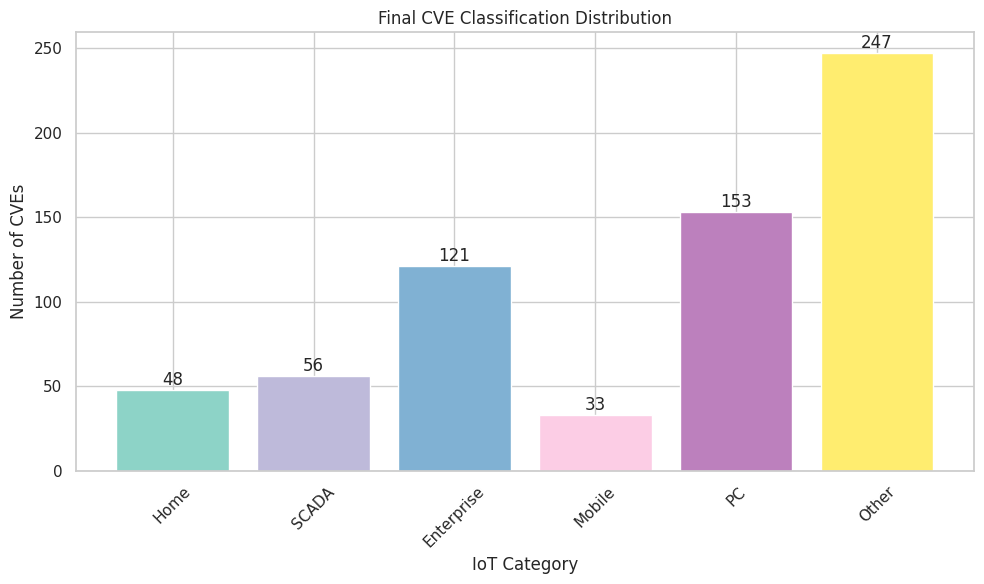

In [25]:
# ==================== SAVE RESULTS ====================
print("\n" + "="*60)
print("SAVING RESULTS")
print("="*60)

# Create final results DataFrame
results_df = pd.DataFrame({
    'cve_id': df['cve_id'],
    'description': df['text'].str[:200],  # Truncate for readability
    'vendor': [row['vendor'].title() if row['vendor'] else 'Unknown' for _, row in df.iterrows()],
    'product': [row['product'].title() if row['product'] else 'Unknown' for _, row in df.iterrows()],
    'rule_based_label': df['rule_label'],
    'svm_label': df['svm_label'],
    'svm_confidence': df['svm_confidence'],
    'final_label': df['svm_label'],  # Using SVM labels as final
})

# Save to CSV
output_file = "cve_classification_results.csv"
results_df.to_csv(output_file, index=False)
print(f"\nResults saved to: {output_file}")

# Summary statistics
print("\n" + "="*60)
print("FINAL CLASSIFICATION SUMMARY")
print("="*60)

final_counts = results_df['final_label'].value_counts().reindex(LABELS, fill_value=0)
total = len(results_df)

print("\nFinal Distribution:")
print("-" * 40)
for label in LABELS:
    count = final_counts.get(label, 0)
    percentage = (count / total * 100)
    print(f"{label:15s}: {count:4d} ({percentage:.1f}%)")

print(f"\nTotal CVEs: {total}")
print(f"Reduction in 'Other' category: {len(other_samples) - final_counts.get('Other', 0)}")
print(f"New 'Other' percentage: {final_counts.get('Other', 0)/total*100:.1f}%")

# Visualization of final distribution
plt.figure(figsize=(10, 6))
colors = plt.cm.Set3(np.linspace(0, 1, len(LABELS)))
bars = plt.bar(LABELS, [final_counts.get(label, 0) for label in LABELS], color=colors)
plt.title('Final CVE Classification Distribution')
plt.xlabel('IoT Category')
plt.ylabel('Number of CVEs')
plt.xticks(rotation=45)

# Add counts on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Problem 3 Using SecureBERT 2.0

In [26]:
# ==================== 1. SETUP AND IMPORTS ====================
import json
import re
import random
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# For transformer models
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

In [27]:
def extract_description(cve_json):
    """Extract description from CVE JSON"""
    try:
        descs = cve_json["containers"]["cna"].get("descriptions", [])
        if descs:
            return descs[0]["value"]
    except KeyError:
        pass
    return ""

def extract_vendor_product(cve_json):
    """Extract vendor and product information from CVE JSON"""
    vendor = "Unknown"
    product = "Unknown"
    
    try:
        affected = cve_json["containers"]["cna"].get("affected", [])
        if affected:
            vendor = affected[0].get("vendor", "Unknown")
            product = affected[0].get("product", "Unknown")
    except (KeyError, IndexError):
        pass
    
    if vendor == "Unknown":
        try:
            adp = cve_json["containers"].get("adp", [])
            for item in adp:
                affected = item.get("affected", [])
                if affected:
                    vendor = affected[0].get("vendor", "Unknown")
                    product = affected[0].get("product", "Unknown")
                    if vendor != "Unknown":
                        break
        except (KeyError, IndexError):
            pass
    
    return vendor, product

def extract_additional_info(cve_json):
    """Extract additional information that might be useful"""
    info = {}
    
    try:
        # Extract references
        references = cve_json["containers"]["cna"].get("references", [])
        info["reference_count"] = len(references)
        
        # Extract problem type
        problem_types = cve_json["containers"]["cna"].get("problemTypes", [])
        if problem_types:
            info["problem_type"] = str(problem_types[0].get("descriptions", [{}])[0].get("value", ""))
        else:
            info["problem_type"] = ""
            
        # Extract impact
        impacts = cve_json["containers"]["cna"].get("impacts", [])
        if impacts:
            info["impact"] = str(impacts[0].get("descriptions", [{}])[0].get("value", ""))
        else:
            info["impact"] = ""
            
    except KeyError:
        info["reference_count"] = 0
        info["problem_type"] = ""
        info["impact"] = ""
    
    return info

In [28]:
# Define label space
LABELS = [
    "Home_IoT",           # Smart home devices, routers, cameras
    "SCADA_Industrial",   # Industrial control systems, medical devices
    "Enterprise",         # Servers, networking equipment, enterprise software
    "Mobile",             # Smartphones, tablets, wearables
    "PC",                 # Desktops, laptops, personal computing
    "Other"               # Everything else
]

label2id = {l: i for i, l in enumerate(LABELS)}
id2label = {i: l for i, l in enumerate(LABELS)}

In [29]:
def load_and_prepare_data(json_files, max_files=None):
    """Load CVE data and extract features"""
    data = []
    
    files_to_process = json_files[:max_files] if max_files else json_files
    
    for idx, json_file in enumerate(files_to_process):
        if idx % 100 == 0:
            print(f"Processing {idx}/{len(files_to_process)}...")
        
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                cve_data = json.load(f)
            
            # Extract basic info
            description = extract_description(cve_data)
            if not description.strip():
                continue
                
            vendor, product = extract_vendor_product(cve_data)
            additional_info = extract_additional_info(cve_data)
            
            # Enhanced text with additional context
            enhanced_text = f"{description} "
            if vendor != "Unknown":
                enhanced_text += f"Vendor: {vendor}. "
            if product != "Unknown":
                enhanced_text += f"Product: {product}. "
            if additional_info["problem_type"]:
                enhanced_text += f"Problem type: {additional_info['problem_type']}. "
            
            data.append({
                "file_name": str(json_file.name),
                "text": enhanced_text,
                "description": description,
                "vendor": vendor,
                "product": product,
                "reference_count": additional_info["reference_count"],
                "problem_type": additional_info["problem_type"],
                "impact": additional_info["impact"],
                "full_data": cve_data  # Keep for reference
            })
            
        except (json.JSONDecodeError, KeyError) as e:
            continue
    
    return pd.DataFrame(data)

# Load your data
root_folder = Path("../data/dataset_sw+fw")
json_files = list(root_folder.rglob("*.json"))
print(f"Found {len(json_files)} JSON files.")

# Load subset for training (adjust based on your resources)
df = load_and_prepare_data(json_files, max_files=1000)  # Start with 1000
print(f"Loaded {len(df)} CVEs with complete information")

Found 658 JSON files.
Processing 0/658...
Processing 100/658...
Processing 200/658...
Processing 300/658...
Processing 400/658...
Processing 500/658...
Processing 600/658...
Loaded 658 CVEs with complete information


In [30]:
def rule_based_classify(row):
    """Enhanced rule-based classifier using text, vendor, and product"""
    text = row['text'].lower()
    vendor = row['vendor'].lower()
    product = row['product'].lower()
    
    # Define comprehensive patterns
    patterns = {
        "Home_IoT": [
            r"smart\s+(home|thermostat|bulb|lock|speaker|tv|plug|camera|doorbell|hub)",
            r"iot\s+device", r"connected\s+device", r"home\s+automation",
            r"router", r"wifi", r"wireless", r"access\s+point",
            r"security\s+camera", r"ip\s+camera", r"baby\s+monitor",
            r"smart\s+tv", r"streaming\s+device", r"gaming\s+console",
            r"d-link", r"tplink", r"netgear", r"linksys", r"asus",
            r"nest", r"ring", r"arlo", r"wyze", r"roku", r"google\s+home",
            r"amazon\s+echo", r"philips\s+hue", r"smartthings",
            r"ecobee", r"eufy", r"blink", r"simplisafe"
        ],
        "SCADA_Industrial": [
            r"\b(scada|ics|plc|hmi|rtu|dcs)\b", r"industrial\s+control",
            r"process\s+control", r"supervisory\s+control",
            r"power\s+(grid|plant|station)", r"water\s+treatment",
            r"medical\s+device", r"patient\s+monitor", r"hospital\s+equipment",
            r"manufacturing", r"factory", r"plant", r"automotive",
            r"vehicle", r"car", r"engine\s+control",
            r"siemens", r"rockwell", r"schneider", r"abb", r"emerson",
            r"honeywell", r"mitsubishi", r"omron", r"fanuc"
        ],
        "Enterprise": [
            r"enterprise", r"business", r"corporate", r"cloud",
            r"server", r"data\s+center", r"switch", r"firewall",
            r"vpn", r"load\s+balancer", r"storage\s+system",
            r"cisco", r"juniper", r"paloalto", r"fortinet", r"vmware",
            r"microsoft\s+server", r"oracle", r"sap", r"red\s+hat",
            r"dell\s+(server|poweredge)", r"hp\s+proliant"
        ],
        "Mobile": [
            r"\b(android|ios|iphone|ipad|smartphone|tablet)\b",
            r"mobile\s+(device|phone|app|os)", r"google\s+play",
            r"app\s+store", r"smartwatch", r"wearable", r"fitness\s+tracker",
            r"samsung\s+galaxy", r"apple\s+watch", r"huawei", r"xiaomi"
        ],
        "PC": [
            r"\b(pc|computer|desktop|laptop|notebook)\b",
            r"personal\s+computer", r"operating\s+system",
            r"\b(windows|linux|macos|ubuntu|debian)\b",
            r"\b(bios|uefi|cpu|gpu|ram|ssd|hard\s+drive)\b",
            r"microsoft\s+office", r"adobe", r"antivirus", r"browser",
            r"intel", r"amd", r"nvidia", r"dell\s+(inspiron|xps)",
            r"hp\s+(pavilion|envy)", r"lenovo\s+thinkpad"
        ]
    }
    
    scores = {}
    
    # Score based on patterns in text
    for category, regex_list in patterns.items():
        score = 0
        for pattern in regex_list:
            if re.search(pattern, text):
                score += 2
            if re.search(pattern, vendor):
                score += 3  # Vendor match gets higher weight
            if re.search(pattern, product):
                score += 3  # Product match gets higher weight
        if score > 0:
            scores[category] = score
    
    # Return best match
    if scores:
        best_category = max(scores.items(), key=lambda x: x[1])[0]
        return best_category
    
    return "Other"

# Apply rule-based classification
print("Applying rule-based classification...")
df['rule_based_label'] = df.apply(rule_based_classify, axis=1)
df['label'] = df['rule_based_label'].map(label2id)

# Show distribution
print("\nClass Distribution:")
print(df['rule_based_label'].value_counts())

Applying rule-based classification...

Class Distribution:
rule_based_label
Other               232
PC                  126
Enterprise          125
Home_IoT             84
SCADA_Industrial     57
Mobile               34
Name: count, dtype: int64


In [31]:
# Split data
train_df, eval_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42,
    stratify=df['label']
)

# Create HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
eval_dataset = Dataset.from_pandas(eval_df[['text', 'label']])

dataset = DatasetDict({
    'train': train_dataset,
    'validation': eval_dataset
})

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(eval_dataset)}")

Training samples: 526
Validation samples: 132


In [32]:
# Option 1: Use SecureBERT (if available) or similar security-focused model
# Option 2: Use general BERT model fine-tuned on security text
# Option 3: Use DistilBERT for faster training

# MODEL_NAME = "distilbert-base-uncased"  # Start with this for speed
# MODEL_NAME = "bert-base-uncased"  # More accurate but slower
# MODEL_NAME = "microsoft/codebert-base"  # Good for technical text
# MODEL_NAME = "roberta-base"  # Another good option
# --- SecureBERT 2.0 setup ---
MODEL_NAME = "cisco-ai/SecureBERT2.0-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

# Tokenize datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Remove text column and keep only needed columns
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/526 [00:00<?, ? examples/s]

Map:   0%|          | 0/132 [00:00<?, ? examples/s]

In [33]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(LABELS),
    id2label=id2label,
    label2id=label2id
)

# Define compute_metrics function
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    acc = accuracy_score(labels, predictions)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./cve_classifier_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir='./logs',
    logging_steps=10,
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)

# Train the model
print("Training model...")
trainer.train()

# Evaluate
print("\nEvaluating model...")
eval_results = trainer.evaluate()
print(f"Validation results: {eval_results}")

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at cisco-ai/SecureBERT2.0-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.368000,1.372327,0.484848,0.415398,0.519859,0.484848
2,1.054800,1.088732,0.575758,0.556215,0.608890,0.575758
3,0.727500,1.090196,0.666667,0.663438,0.668318,0.666667


/home/ab/updatOR/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Evaluating model...


Validation results: {'eval_loss': 1.0901957750320435, 'eval_accuracy': 0.6666666666666666, 'eval_f1': 0.6634380177396306, 'eval_precision': 0.6683179194542831, 'eval_recall': 0.6666666666666666, 'eval_runtime': 1.2706, 'eval_samples_per_second': 103.891, 'eval_steps_per_second': 13.38, 'epoch': 3.0}


In [34]:
# Save the trained model
model.save_pretrained("./cve_classifier_model")
tokenizer.save_pretrained("./cve_classifier_model")

# Load for inference
def load_classifier(model_path="./cve_classifier_model"):
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    classifier = pipeline(
        "text-classification",
        model=model,
        tokenizer=tokenizer,
        device=0 if torch.cuda.is_available() else -1
    )
    return classifier

# Create classifier pipeline
classifier = load_classifier()

Device set to use cuda:0


In [45]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

class SecureBERT2Classifier:
    def __init__(self, model_path, rule_classifier, device=None):
        self.rule_classifier = rule_classifier

        self.device = device or (
            "cuda:0" if torch.cuda.is_available() else "cpu"
        )

        print(f"Device set to use {self.device}")

        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.model.to(self.device)
        self.model.eval()

        self.id2label = self.model.config.id2label

    def bert_predict(self, text: str) -> str:
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=256
        ).to(self.device)

        with torch.no_grad():
            logits = self.model(**inputs).logits
            pred_id = torch.argmax(logits, dim=1).item()

        return self.id2label[pred_id]

    def predict(self, text: str) -> dict:
        rule_label = self.rule_classifier.predict(text)

        if rule_label != "Unknown":
            return {
                "label": rule_label,
                "source": "rule-based"
            }

        return {
            "label": self.bert_predict(text),
            "source": "SecureBERT2.0"
        }


In [46]:
predictions = []

for _, row in df.iterrows():
    result = securebert.predict(row["description"])
    predictions.append(result)

df["Predicted_Label"] = [p["label"] for p in predictions]
df["Classifier"] = [p["source"] for p in predictions]


NameError: name 'securebert' is not defined

Found 658 JSON files.
Loaded CVE-2022-32259.json
Loaded CVE-2019-4640.json
Loaded CVE-2022-38101.json
Loaded CVE-2019-1880.json
Loaded CVE-2022-38625.json
Enhanced classification complete: 658 CVEs

 ENHANCED Class Distribution (with Vendor/Product info)

 IoT Class Distribution (Enhanced):
-----------------------------------
 1  Home               48 (7.3%)
 2  SCADA              55 (8.4%)
 3  Enterprise        119 (18.1%)
 4  Mobile             33 (5.0%)
 5  PC                153 (23.3%)
 6  Other             250 (38.0%)


/tmp/ipykernel_21366/2160607316.py:323: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


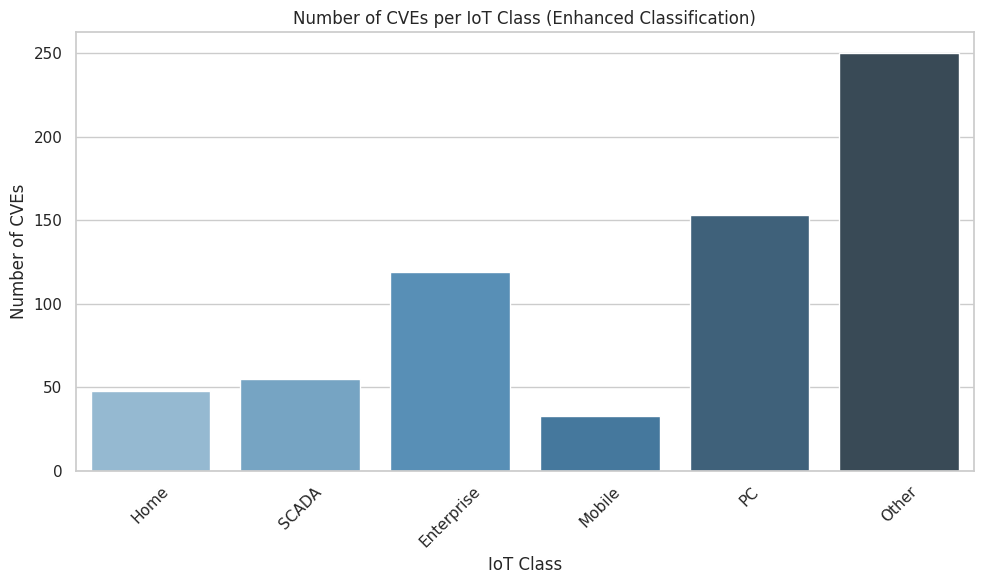


 Sample CVEs per IoT Class

HOME CLASS (48 CVEs)
----------------------------------------

CVE: CVE-2019-9126.json
Vendor: n/a
Product: n/a
Description: An issue was discovered on D-Link DIR-825 Rev.B 2.10 devices. There is an information disclosure vulnerability via requests for the router_info.xml do...
------------------------------

CVE: CVE-2022-46422.json
Vendor: n/a
Product: n/a
Description: An issue in Netgear WNR2000 v1 1.2.3.7 and earlier allows authenticated attackers to cause a Denial of Service (DoS) via uploading a crafted firmware ...
------------------------------

CVE: CVE-2022-26510.json
Vendor: InHand Networks
Product: InRouter302
Description: A firmware update vulnerability exists in the iburn firmware checks functionality of InHand Networks InRouter302 V3.5.37. A specially-crafted HTTP req...
------------------------------

SCADA CLASS (55 CVEs)
----------------------------------------

CVE: CVE-2018-7777.json
Vendor: Schneider Electric SE
Product: U.Motion
Descri

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import re
import random
from pathlib import Path
from datasets import Dataset

# ==================== 1. LOAD JSON FILES ====================
root_folder = Path("../data/dataset_sw+fw")
json_files = list(root_folder.rglob("*.json"))
print(f"Found {len(json_files)} JSON files.")

# Load a few sample files to verify
for file_path in json_files[:5]:
    with open(file_path) as f:
        data = json.load(f)
    print(f"Loaded {file_path.name}")

# ==================== 2. EXTRACT DESCRIPTION FUNCTION ====================
def extract_description(cve_json):
    try:
        descs = cve_json["containers"]["cna"].get("descriptions", [])
        if descs:
            return descs[0]["value"]
    except KeyError:
        pass
    return ""

# ==================== 3. EXTRACT VENDOR/PRODUCT FUNCTION ====================
def extract_vendor_product(cve_json):
    vendor = "Unknown"
    product = "Unknown"
    
    try:
        affected = cve_json["containers"]["cna"].get("affected", [])
        if affected:
            vendor = affected[0].get("vendor", "Unknown")
            product = affected[0].get("product", "Unknown")
    except (KeyError, IndexError):
        pass
    
    if vendor == "Unknown":
        try:
            adp = cve_json["containers"].get("adp", [])
            for item in adp:
                affected = item.get("affected", [])
                if affected:
                    vendor = affected[0].get("vendor", "Unknown")
                    product = affected[0].get("product", "Unknown")
                    if vendor != "Unknown":
                        break
        except (KeyError, IndexError):
            pass
    
    return vendor, product

# ==================== 4. LABEL DEFINITION ====================
LABELS = ["Home", "SCADA", "Enterprise", "Mobile", "PC", "Other"]
label2id = {l: i for i, l in enumerate(LABELS)}
id2label = {i: l for l, i in label2id.items()}

# ==================== 5. RULE-BASED CLASSIFIER (ORIGINAL) ====================
def classify_cve_iot_category(cve):
    """Enhanced rule-based classifier with better keyword coverage"""
    desc = extract_description(cve).lower()
    
    patterns = {
        "Home": [
            r"smart\s+(home|thermostat|bulb|lock|speaker|tv|plug|camera|doorbell)",
            r"iot\s+device",
            r"connected\s+device",
            r"home\s+automation",
            r"\b(router|wifi|wireless)\s+(router|access\s+point|device)",
            r"\b(tplink|d-link|asus|netgear|linksys|nest|ring|arlo|wyze|roku)\b",
            r"security\s+camera",
            r"ip\s+camera",
            r"baby\s+monitor",
            r"smart\s+tv",
            r"streaming\s+device",
            r"gaming\s+console",
            r"\b(soho|home\s+router)\b"
        ],
        
        "SCADA": [
            r"\b(scada|ics|plc|hmi|rtu|dcs)\b",
            r"industrial\s+control",
            r"process\s+control",
            r"supervisory\s+control",
            r"power\s+(grid|plant|station)",
            r"water\s+treatment",
            r"\b(oil|gas)\s+.*\s+(plant|refinery|pipeline)",
            r"medical\s+device",
            r"patient\s+monitor",
            r"hospital\s+equipment",
            r"\b(manufacturing|factory|plant)\b",
            r"\b(automotive|vehicle|car)\b",
            r"engine\s+control"
        ],
        
        "Enterprise": [
            r"enterprise\s+(network|system|software|application)",
            r"business\s+(network|application)",
            r"corporate\s+(network|environment)",
            r"cloud\s+(service|infrastructure|platform)",
            r"data\s+center",
            r"server\s+(software|application|side|hardware)",
            r"\b(switch|firewall|vpn|load\s+balancer)\b",
            r"\b(cisco|juniper|paloalto|fortinet|vmware|oracle|sap|microsoft\s+server)\b",
            r"storage\s+system",
            r"\b(nas|san)\b"
        ],
        
        "Mobile": [
            r"\b(android|ios|iphone|ipad|smartphone|tablet)\b",
            r"mobile\s+(device|phone|application|app|os)",
            r"google\s+play",
            r"app\s+store",
            r"\b(smartwatch|wearable|fitness\s+tracker)\b",
            r"\b(5g|lte|cellular)\b"
        ],
        
        "PC": [
            r"\b(pc|computer|desktop|laptop|notebook)\b",
            r"personal\s+computer",
            r"\b(windows|linux|macos|ubuntu|debian|centos|red\s+hat)\b",
            r"operating\s+system",
            r"\b(bios|uefi|cpu|gpu|ram|ssd|hard\s+drive|motherboard)\b",
            r"\b(microsoft\s+office|adobe|antivirus|browser)\b",
            r"\b(intel\s+nuc|chrome\s+os)\b"
        ]
    }

    scores = {}
    for category, regex_list in patterns.items():
        score = 0
        for pattern in regex_list:
            matches = re.findall(pattern, desc)
            if matches:
                if "\\s" in pattern:
                    score += len(matches) * 3
                else:
                    score += len(matches) * 2
        if score > 0:
            scores[category] = score
    
    if scores:
        best_category, best_score = max(scores.items(), key=lambda x: x[1])
        if best_score >= 2:
            return best_category
    
    return "Other"

# ==================== 6. VENDOR/PRODUCT CATEGORIES ====================
vendor_categories = {
    "Home": [
        "d-link", "tplink", "asus", "netgear", "linksys", "nest", "ring", "arlo", 
        "wyze", "roku", "google", "amazon", "apple", "samsung", "xiaomi", "philips",
        "hue", "smartthings", "ecobee", "eufy", "blink", "simplisafe",
        "logitech", "harman", "sonos", "bose", "jbl", "belkin", "meross", "tuya"
    ],
    "SCADA": [
        "siemens", "rockwell", "schneider", "abb", "emerson", "honeywell", "yokogawa",
        "mitsubishi", "omron", "fanuc", "beckhoff", "wago", "moxa", "advantech",
        "b&r", "panasonic", "delta", "fujitsu", "hitachi", "toshiba", "general electric",
        "ge", "allen-bradley", "modicon", "telemecanique", "square d", "cutler-hammer"
    ],
    "Enterprise": [
        "cisco", "juniper", "paloalto", "fortinet", "checkpoint", "f5", "arista",
        "extreme", "brocade", "hp", "hewlett-packard", "dell", "ibm", "oracle",
        "sap", "vmware", "red hat", "microsoft", "intel", "amd", "nvidia", "qualcomm",
        "broadcom", "marvell", "micron", "sandisk", "seagate", "western digital",
        "synology", "qnap", "netapp", "emc", "hitachi", "huawei", "zte", "ericsson",
        "nokia", "motorola", "aruba", "ruckus", "ubiquiti"
    ],
    "Mobile": [
        "apple", "samsung", "google", "huawei", "xiaomi", "oppo", "vivo", "oneplus",
        "sony", "lg", "motorola", "nokia", "htc", "blackberry", "asus", "lenovo",
        "zte", "alcatel", "realme", "tecno", "infinix", "fairphone", "nothing"
    ],
    "PC": [
        "dell", "hp", "hewlett-packard", "lenovo", "asus", "acer", "msi", "gigabyte",
        "intel", "amd", "nvidia", "microsoft", "apple", "toshiba", "fujitsu", "samsung",
        "lg", "sony", "panasonic", "sharp", "nec", "epson", "brother", "canon", "ricoh",
        "kyocera", "xerox", "lexmark", "okidata", "konica", "minolta"
    ]
}

product_keywords = {
    "Home": [
        "router", "access point", "mesh", "wifi", "camera", "doorbell", "thermostat",
        "bulb", "light", "plug", "outlet", "switch", "lock", "speaker", "display",
        "hub", "gateway", "bridge", "extender", "repeater", "adapter", "dongle"
    ],
    "SCADA": [
        "plc", "hmi", "rtu", "dcs", "scada", "ics", "controller", "automation",
        "drive", "inverter", "servo", "motor", "sensor", "actuator", "valve",
        "transmitter", "recorder", "logger", "monitor", "panel", "station"
    ],
    "Enterprise": [
        "switch", "firewall", "router", "load balancer", "server", "storage",
        "nas", "san", "array", "appliance", "gateway", "proxy", "vpn", "wireless",
        "controller", "management", "console", "director", "orchestrator", "hypervisor"
    ],
    "Mobile": [
        "phone", "smartphone", "tablet", "pad", "watch", "wearable", "tracker",
        "band", "bracelet", "ring", "glasses", "headset", "earbuds", "charger",
        "battery", "dock", "station", "adapter", "cable"
    ],
    "PC": [
        "laptop", "notebook", "desktop", "pc", "workstation", "server", "all-in-one",
        "mini", "stick", "dongle", "adapter", "card", "motherboard", "cpu", "gpu",
        "ram", "ssd", "hdd", "drive", "monitor", "display", "printer", "scanner",
        "copier", "fax", "projector", "keyboard", "mouse", "webcam", "microphone"
    ]
}

# ==================== 7. ENHANCED CLASSIFIER ====================
def enhanced_classify_cve(cve):
    """Enhanced classifier that uses vendor and product information"""
    desc = extract_description(cve).lower()
    vendor, product = extract_vendor_product(cve)
    vendor_lower = vendor.lower()
    product_lower = product.lower()
    
    scores = {}
    
    # 1. Check vendor categories
    for category, vendors in vendor_categories.items():
        for known_vendor in vendors:
            if known_vendor in vendor_lower:
                scores[category] = scores.get(category, 0) + 3
    
    # 2. Check product keywords
    for category, keywords in product_keywords.items():
        for keyword in keywords:
            if keyword in product_lower:
                scores[category] = scores.get(category, 0) + 2
            if keyword in desc:
                scores[category] = scores.get(category, 0) + 1
    
    # 3. Use the original text-based classifier
    rule_label = classify_cve_iot_category(cve)
    if rule_label != "Other":
        scores[rule_label] = scores.get(rule_label, 0) + 2
    
    # Return best match if above threshold
    if scores:
        best_category, best_score = max(scores.items(), key=lambda x: x[1])
        if best_score >= 2:
            return best_category
    
    return "Other"

# ==================== 8. BUILD DATASET WITH ENHANCED CLASSIFICATION ====================
texts = []
labels = []
rule_predictions = []
vendors = []
products = []
file_names = []

for json_file in json_files:
    with open(json_file, "r", encoding="utf-8") as f:
        try:
            cve = json.load(f)
        except json.JSONDecodeError:
            continue
    
    desc = extract_description(cve)
    if desc.strip() == "":
        continue
    
    vendor, product = extract_vendor_product(cve)
    
    # Use the enhanced classifier
    rule_label = enhanced_classify_cve(cve)
    label_id = label2id[rule_label]
    
    texts.append(desc)
    labels.append(label_id)
    vendors.append(vendor)
    products.append(product)
    rule_predictions.append(rule_label)
    file_names.append(json_file.name)

print(f"Enhanced classification complete: {len(rule_predictions)} CVEs")

# Create dataset
dataset = Dataset.from_dict({
    "text": texts,
    "label": labels
})

# ==================== 9. PRINT ENHANCED CLASS DISTRIBUTION ====================
print("\n" + "="*50)
print(" ENHANCED Class Distribution (with Vendor/Product info)")
print("="*50)

CLASS_ORDER = ["Home", "SCADA", "Enterprise", "Mobile", "PC", "Other"]

dist_df = pd.DataFrame({
    "IoT_Class": rule_predictions,
    "Label_ID": labels,
    "Vendor": vendors,
    "Product": products,
    "CVE_File": file_names
})

# Count distribution
dist_counts_vendor = dist_df["IoT_Class"].value_counts().reindex(CLASS_ORDER, fill_value=0).reset_index()
dist_counts_vendor.columns = ["IoT_Class", "Count"]
dist_counts_vendor["Percentage"] = (dist_counts_vendor["Count"] / len(dist_df) * 100).round(1)

print("\n IoT Class Distribution (Enhanced):")
print("-" * 35)
for idx, row in dist_counts_vendor.iterrows():
    print(f"{idx+1:2d}  {row['IoT_Class']:15s} {row['Count']:5d} ({row['Percentage']}%)")

# ==================== 10. VISUALIZATION ====================
plt.figure(figsize=(10, 6))
sns.barplot(
    data=dist_counts_vendor,
    x="IoT_Class",
    y="Count",
    order=dist_counts_vendor["IoT_Class"],
    palette="Blues_d"
)

plt.title("Number of CVEs per IoT Class (Enhanced Classification)")
plt.xlabel("IoT Class")
plt.ylabel("Number of CVEs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ==================== 11. SAMPLE CVEs PER CLASS ====================
print("\n" + "="*50)
print(" Sample CVEs per IoT Class")
print("="*50)

for class_name in CLASS_ORDER:
    class_indices = [i for i, label in enumerate(rule_predictions) if label == class_name]
    
    if class_indices:
        print(f"\n{class_name.upper()} CLASS ({len(class_indices)} CVEs)")
        print("-" * 40)
        
        if len(class_indices) > 3:
            selected_indices = random.sample(class_indices, 3)
        else:
            selected_indices = class_indices
        
        for idx in selected_indices:
            cve_name = file_names[idx]
            cve_vendor = vendors[idx] if idx < len(vendors) else "Unknown"
            cve_product = products[idx] if idx < len(products) else "Unknown"
            
            print(f"\nCVE: {cve_name}")
            print(f"Vendor: {cve_vendor}")
            print(f"Product: {cve_product}")
            
            with open(json_files[idx], "r", encoding="utf-8") as f:
                cve_data = json.load(f)
            desc = extract_description(cve_data)
            
            short_desc = desc[:150]
            if len(desc) > 150:
                short_desc = desc[:150] + "..."
            print(f"Description: {short_desc}")
            print("-" * 30)

# ==================== 12. SAVE RESULTS ====================
results_df = pd.DataFrame({
    'CVE_File': file_names,
    'Description': texts,
    'Vendor': vendors,
    'Product': products,
    'IoT_Class': rule_predictions,
    'Label_ID': labels
})

# Save to CSV for further analysis
results_df.to_csv('cve_iot_classification_results.csv', index=False)
print(f"\nResults saved to 'cve_iot_classification_results.csv'")
print(f"Total CVEs classified: {len(results_df)}")